## Part 4: Network analysis

In [88]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from utils.functions import truncate

In [89]:
sfw_matrix = pd.read_pickle('results/sfw_matrix.pickle')
trophic_levels = pd.read_pickle('results/trophic_levels.pickle')
G = nx.read_gpickle('results/G.pickle')

In [90]:
# Strongly connected: no
# Density: 0.17029
# find diameter

### 4.1 Network chracteristics (complexity, connectance, connectedness)

Complexity as the average number of links per species (*Christian needs to confirm and which one to use?)

In [91]:
# Complexity (average number of links per species (Wikipedia())
from statistics import mean
def complexity(g):
    """Calculates the average number of edges (degree) per node in a graph g"""
    deg = g.degree()
    deg_ls = []
    for n, d in deg:
        deg_ls.append(d)
    
    return mean(deg_ls) 

# Connectance
connectance = G.number_of_edges() / (G.number_of_nodes())**2

print(f"Complexity: {complexity(G)}")
print(f"Connectance: {connectance}") 

Complexity: 7.833333333333333
Connectance: 0.16319444444444445


In [175]:
nx.edge_connectivity(G)

0

#### 4.1.# Degree distribution

Degree distribution summarizes the graph in a way which indicates its structure, e.g., homogeneous structure vs. singletons and hubs.

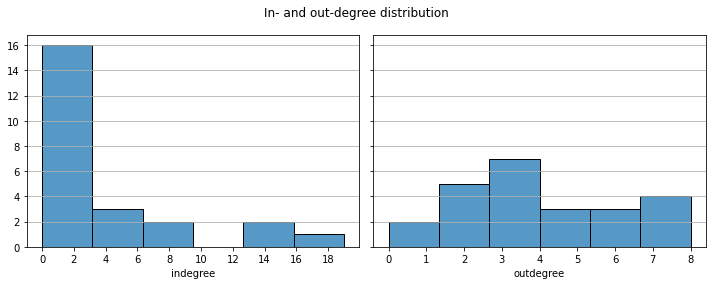

In [121]:
degrees = pd.DataFrame({'node': [x[0] for x in G.in_degree()],
                        'indegree': [x[1] for x in G.in_degree()],
                        'outdegree': [x[1] for x in G.out_degree()]
                       })
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), sharey='row')
fig.suptitle('In- and out-degree distribution')
sns.histplot(data=degrees, x='indegree', ax=ax1)
ax1.set_xticks(np.arange(0,20,2))
ax1.grid(which='major', axis='y')
ax1.set(ylabel=None)

sns.histplot(data=degrees, x='outdegree', ax=ax2)
ax2.grid(which='major', axis='y')
fig.tight_layout()

### 4.2 Identyfing key nodes and edges

#### 4.2.1 Degree ratio
The degree ratio [1] assigns to every node in a digraph its outdegree divided by its indegree. To avoid dividing by zero, 1 is added to both the out- as well as indegree of every node. This measeure is similar to the Copeland score but can give different results in some situations.

_René van den Brink, Agnieszka Rusinowska, The degree ratio ranking method for directed graphs, European Journal of Operational Research, Volume 288, Issue 2, 2021, Pages 563-575._

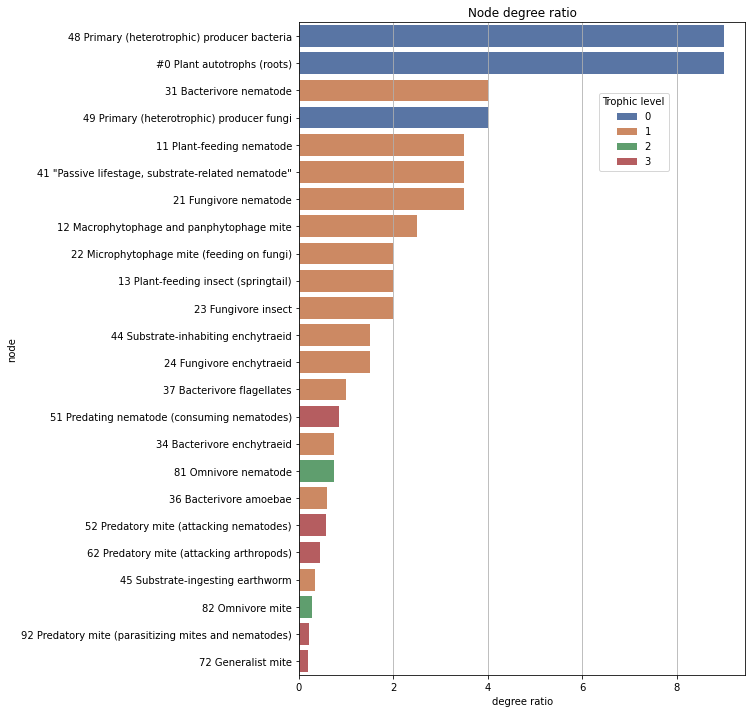

In [126]:
degrees['degree ratio'] = (degrees['outdegree'] + 1) / (degrees['indegree'] + 1)
degrees['trophic level'] = [trophic_levels.to_dict()[node] for node in G.nodes]

fig, plot = plt.subplots(figsize=(8, 12))
ax = sns.barplot(x="degree ratio", y="node", hue='trophic level', 
                 data=degrees.sort_values(by='degree ratio', ascending=False), 
                 dodge=False, palette='deep')
ax.grid(which='major', axis='x')
ax.legend(loc='upper center', title='Trophic level',  bbox_to_anchor=(0.75, 0.90))
_ = ax.set_title('Node degree ratio')

#### 4.2.3 Node centrality measures

Centrality is one of the measures of the importance of a node in the graph. Here we compute some of the most typical centrality measures and plot them together for a better comparison.

In [95]:
from utils.ui_functions import make_download_button

df_measures = pd.DataFrame.from_dict({"degree centrality": nx.degree_centrality(G),
                                      "out-degree centrality": nx.out_degree_centrality(G),
                                      "in-degree centrality": nx.in_degree_centrality(G),
                                      "betweenness centrality": nx.betweenness_centrality(G),
                                      "closeness centrality": nx.closeness_centrality(G),
                                     "eigenvector centrality": nx.eigenvector_centrality(G)})
df_measures.index.name = 'trophic group'
display(make_download_button('centrality_measures.csv', raw_contents=df_measures.to_csv()))

HTML(value='<html>\n<head>\n<meta name="viewport" content="width=device-width, initial-scale=1">\n</head>\n<bo…

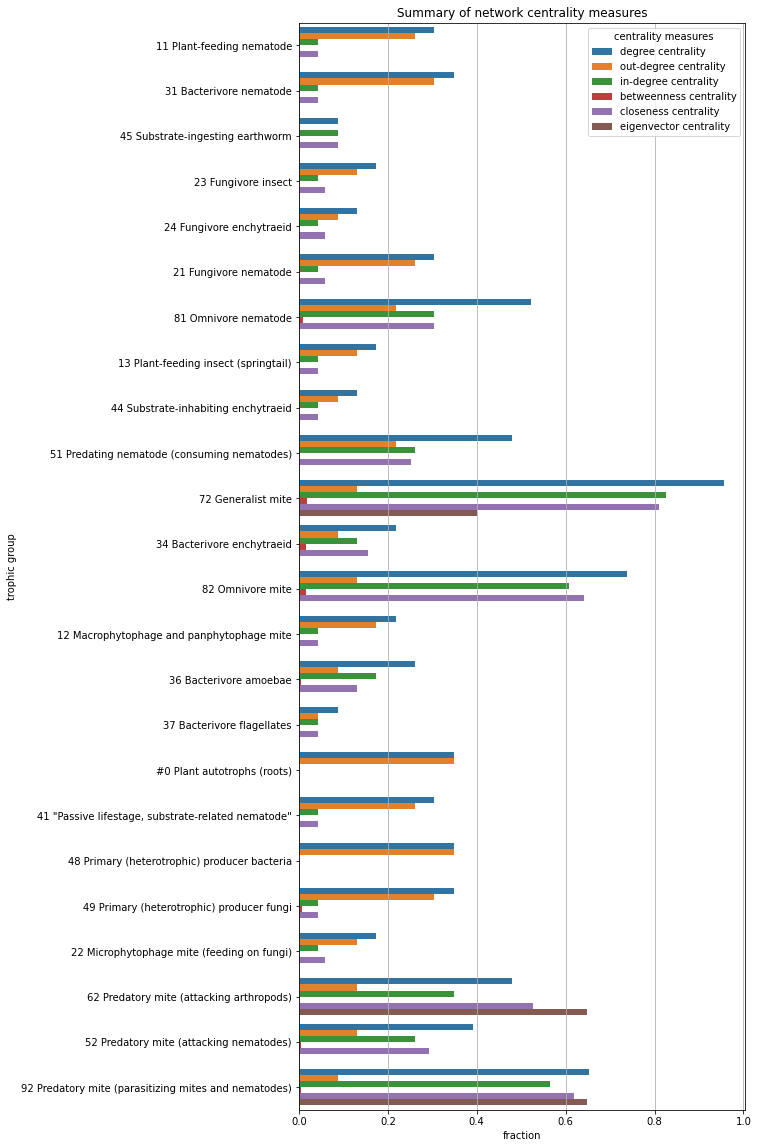

In [96]:
# to long format
df_meassures_melt = df_measures.reset_index()
df_meassures_melt = df_meassures_melt.melt("trophic group", var_name='centrality measures', value_name='fraction')

fig, plot = plt.subplots(figsize=(8, 20))
ax = sns.barplot(x="fraction", y="trophic group", hue='centrality measures', data=df_meassures_melt)
ax.grid(which='major', axis='x')
_ = ax.set_title("Summary of network centrality measures")

# ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
# ax.set_yticks(np.arange(0,1.1,0.1))
# _ = ax.set_ylim(0,1)
# _ = ax.set_xticklabels([truncate(s, 25) for s in df_measures.index])

#### 4.2.4 Edge centrality measures

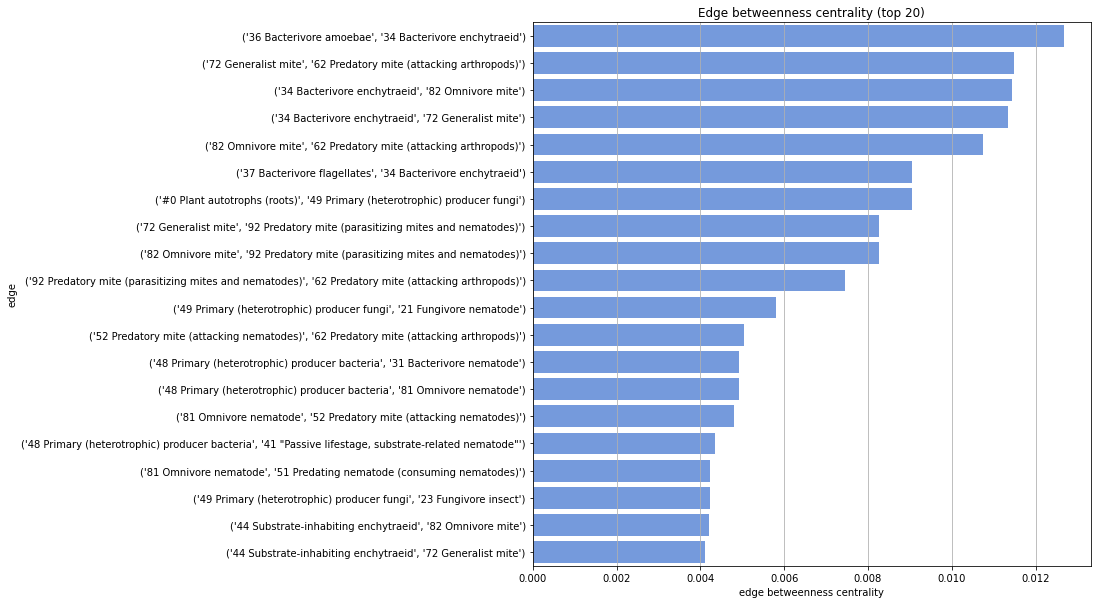

In [155]:
edge_centralities = pd.DataFrame(sorted(nx.centrality.edge_betweenness_centrality(G).items(), reverse=True, key=lambda x: x[1]), 
                                 columns=['edge', 'edge betweenness centrality'])

fig, plot = plt.subplots(figsize=(10, 10))
ax = sns.barplot(x='edge betweenness centrality', y='edge', data=edge_centralities.iloc[:20], color='cornflowerblue')
ax.grid(which='major', axis='x')
_ = ax.set_title('Edge betweenness centrality (top 20)')

### Cuts

In [211]:
nx.minimum_node_cut(nx.Graph(G))
# len(list(nx.components.weakly_connected_components(G))[0])

{'#0 Plant autotrophs (roots)', '48 Primary (heterotrophic) producer bacteria'}

In [99]:
# Find node cut (finding the min list of nodes/edges taht separate the connected graph; )

## Compartment analysis
### Strongly connected components

In [ ]:
# add clustering: by indegree group (0,1,>1), 

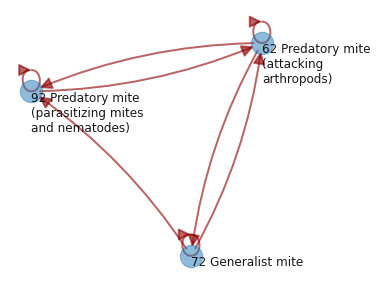

In [284]:
import textwrap

strongly_cc = [x for x in list(nx.components.strongly_connected_components(G)) if len(x) > 1]

for i,x in enumerate(strongly_cc):
    sg = G.subgraph(x)
    fig, ax = plt.subplots(figsize=(5, 5))
    _ = ax.axis('off')
    pos = nx.spring_layout(sg.to_undirected(), k=10, iterations=1000, seed=123)
    nx.draw_networkx_edges(sg, pos, width=2, alpha=0.6, edge_color="darkred", arrows=True, arrowsize=25, connectionstyle='arc3,rad=0.1')
    nx.draw_networkx_nodes(sg, pos, alpha=0.5, node_size=500)
    _ = nx.draw_networkx_labels(sg, pos, alpha=0.9, font_size=12, clip_on=False, 
                                labels={node: '\n'.join(textwrap.wrap(node, 20, break_long_words=True)) for node in sg.nodes},
                                horizontalalignment='left',
                                verticalalignment='top')
    fig.savefig(f'results/figures/strong_cc_{i}.png', bbox_inches='tight')

In [273]:
maxx,maxy, minx, miny

(0.7550525242595232, 0.6922106655993738, -0.9769982833093542, -1.0)

### Transitivity

In [101]:
# sample transitivity triangle, visualise

## 4.3 Derived graphs (indirect interactions)

In [102]:
#to-do prepare derived shared predator and prey graphs

# Others

In [103]:
#node2vec